Epoch 1: Train Accuracy = 0.81, Test Accuracy = 0.81
Epoch 1: Cost = 0.5252911963784316
Epoch 2: Train Accuracy = 0.82, Test Accuracy = 0.83
Epoch 2: Cost = 0.5133144368882433
Epoch 3: Train Accuracy = 0.83, Test Accuracy = 0.83
Epoch 3: Cost = 0.50355254466032
Epoch 4: Train Accuracy = 0.83, Test Accuracy = 0.83
Epoch 4: Cost = 0.4956757819186362
Epoch 5: Train Accuracy = 0.84, Test Accuracy = 0.84
Epoch 5: Cost = 0.489370158518378
Epoch 6: Train Accuracy = 0.84, Test Accuracy = 0.85
Epoch 6: Cost = 0.4843501986117013
Epoch 7: Train Accuracy = 0.84, Test Accuracy = 0.86
Epoch 7: Cost = 0.48036586501705264
Epoch 8: Train Accuracy = 0.84, Test Accuracy = 0.87
Epoch 8: Cost = 0.47720476492038194
Epoch 9: Train Accuracy = 0.84, Test Accuracy = 0.88
Epoch 9: Cost = 0.4746909893184317
Epoch 10: Train Accuracy = 0.85, Test Accuracy = 0.89
Epoch 10: Cost = 0.47268186532400036
Epoch 11: Train Accuracy = 0.85, Test Accuracy = 0.89
Epoch 11: Cost = 0.4710636621234794
Epoch 12: Train Accuracy = 0

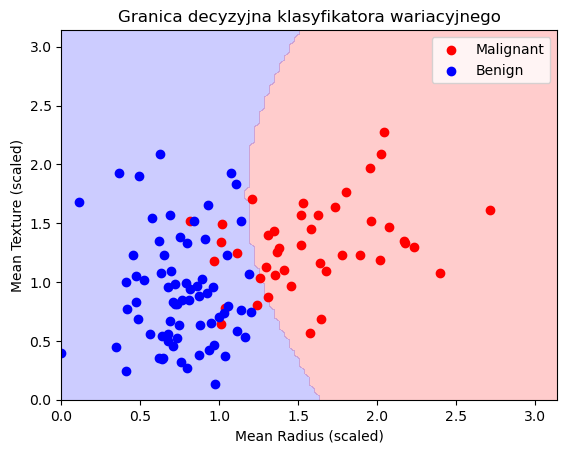

In [7]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Wczytanie i przygotowanie danych
data = load_breast_cancer()
X = data.data
y = data.target

# Wybór dwóch cech dla wizualizacji i uproszczenia
X = X[:, :2]  # np. 'mean radius' i 'mean texture'

# Normalizacja cech do zakresu [0, π]
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X)

# Konwersja etykiet: 0 → -1, 1 → +1
y_converted = 2 * y - 1

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_converted, test_size=0.2, random_state=42)

# 2. Definicja parametrów klasyfikatora
n_qubits = 2
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(weights, x=None):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x=x) + bias

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return np.mean((np.array(predictions) - Y) ** 2)

def accuracy(weights, bias, X, Y):
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    return np.mean(np.array(predictions) == Y)

# 3. Inicjalizacja parametrów
weights_init = 0.01 * np.random.randn(n_layers, n_qubits, 3)
bias_init = 0.0

# 4. Trening klasyfikatora
opt = qml.GradientDescentOptimizer(stepsize=0.1)
epochs = 50
weights = weights_init
bias = bias_init

for epoch in range(epochs):
    # Fixed: The step method returns only 2 values (params, cost)
    weights, bias = opt.step(lambda w, b: cost(w, b, X_train, y_train), weights, bias)
    cost_val = cost(weights, bias, X_train, y_train)
    train_acc = accuracy(weights, bias, X_train, y_train)
    test_acc = accuracy(weights, bias, X_test, y_test)
    print(f"Epoch {epoch+1}: Train Accuracy = {train_acc:.2f}, Test Accuracy = {test_acc:.2f}")
    print(f"Epoch {epoch+1}: Cost = {cost_val}")

# 5. Wizualizacja granicy decyzyjnej
import numpy as np

# Siatka punktów do wizualizacji
xx, yy = np.meshgrid(np.linspace(0, np.pi, 100), np.linspace(0, np.pi, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([np.sign(variational_classifier(weights, bias, x)) for x in grid_points])
Z = Z.reshape(xx.shape)

# Wykres
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.2, colors=['red', 'blue'])
plt.scatter(X_test[:, 0][y_test == -1], X_test[:, 1][y_test == -1], color='red', label='Malignant')
plt.scatter(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1], color='blue', label='Benign')
plt.xlabel('Mean Radius (scaled)')
plt.ylabel('Mean Texture (scaled)')
plt.title('Granica decyzyjna klasyfikatora wariacyjnego')
plt.legend()
plt.show()



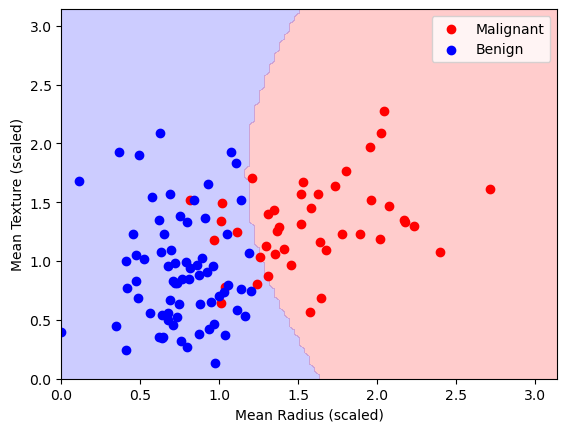

In [9]:
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.2, colors=['red', 'blue'])
plt.scatter(X_test[:, 0][y_test == -1], X_test[:, 1][y_test == -1], color='red', label='Malignant')
plt.scatter(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1], color='blue', label='Benign')
plt.xlabel('Mean Radius (scaled)')
plt.ylabel('Mean Texture (scaled)')
plt.legend()
plt.show()